## Project 2: Feature Detection and Matching
### Gabriel Hofer
### CSC-414 Introduction to Computer Vision
### Instructor: Dr. Randy C. Hoover



### Gaussian Kernel
param r - number of rows  
param c - number of columns  
param s - sigma  
returns 2d numpy array, the gaussian kernel  

In [ ]:
import numpy as np
import math
def gk(r,c,s):
	arr=np.zeros((r,c))
	for i in range(r):
		for j in range(c):
			arr[i,j]=(1/(2*math.pi*s*s))*math.exp(-1*((i-r//2)*(i-r//2)+(j-c//2)*(j-c//2))/(2*s*s))
	return arr


### Harris Corner Detector  
Harris Corner Detection algorithm  
:param img - image, numpy array  
:param g - square guassian matrix, w  
:th - threshold value for R  
:returns - list of pairs. each pair is coordinates of an interst point, (x,y)  

In [ ]:
import numpy as np
import scipy.signal as ss

xsobel = np.array([
    [1,0,-1],
    [2,0,-2],
    [1,0,-1]])

ysobel = np.array([
    [1,2,1],
    [0,0,0],
    [-1,-2,-1]])

def harris(img,g,th):
    n=g.shape[0]
    x=ss.convolve2d(img,xsobel)
    y=ss.convolve2d(img,ysobel)    
    xx=x*x
    yy=y*y
    xy=x*y
    r,c=img.shape[0],img.shape[1]
    avgR=0
    R=125
    feat=[]
    for i in range(r-n):
        for j in range(c-n):
            sxx=(g*xx[i:i+n, j:j+n]).sum()
            syy=(g*yy[i:i+n, j:j+n]).sum()
            sxy=(g*xy[i:i+n, j:j+n]).sum()
            d=(sxx*syy)-(sxy*sxy) 
            t=sxx+syy
            if t!=0:
                R = d/t
            avgR+=R
            if R>th: 
                feat.append([i,j])
    avgR/=r*c
    print("average r: "+str(avgR))
    return feat



### Driver Code for Project 

orig shape: (331, 375, 3)
gray shape: (331, 375)
average r: 0.001409316048801155
number of features: 0
shape of img: (331, 375)
number of descriptors: 0
ONE
TWO
THREE


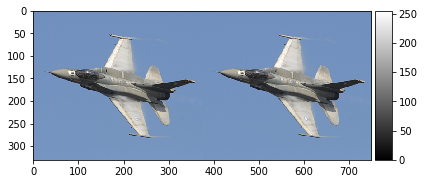

In [3]:
"""
Author: Gabriel Hofer
Course: CSC-414
Instructor: Dr. Randy Hoover
"""
from gk import gk
from harris import harris
from showDots import showDots
import numpy as np
import sys
from skimage import io
from skimage.color import rgb2gray

from showFeatures import showFeatures
from sift import printH, makeH, sift

# read image, convert to gray
#img = io.imread(sys.argv[1]);
img = io.imread("data/plane.bmp");

cpy = img
print("orig shape: "+str(img.shape))
gry = rgb2gray(img)
print("gray shape: "+str(gry.shape))

# get list of locations of interest points
loc = harris(gry,gk(3,3,1),1)
print("number of features: "+str(len(loc)))

# make sift descriptors
D = sift(gry,loc)
print("number of descriptors: "+str(len(D)))

# showFeatures(img,loc,D)
print("ONE")
from matching import matchSIFT
M = matchSIFT(D,D,40,40)
print("TWO")
import cv2
from drawMatches import drawMatches
img2 = drawMatches(img,loc,img,loc,M)
print("THREE")
io.imshow( img2,vmin=0,vmax=255,cmap="gray")
io.show()

#io.imshow((img * 255).astype(np.uint8)  , vmin=0, vmax=255, cmap="gray")
#io.show()
#io.imsave("out.png",img)





### makeH
:returns a histogram  

### Sift Feature Desciptor
:param img - image  
:param feat - list of interest points a.k.a. keypoints  
:returns list of descriptors, [(theta,magnitude)]  


In [ ]:
import numpy as np
from gk import gk
import math

def printH(H):
    for i in H: print(str(i)+' ',end='')
    print()

def makeH(W):
    H=np.zeros(8)
    for i in range(1,5):
        for j in range(1,5):
            m = math.sqrt((W[i+1,j]-W[i-1,j])**2 + (W[i,j+1]-W[i,j-1])**2)
            if W[i,j+1] != W[i,j-1] and W[i+1,j] != W[i-1,j]: 
                theta = math.atan2((W[i+1,j]-W[i-1,j]), (W[i,j+1]-W[i,j-1]))
            else: continue
            norm=int(math.floor((theta+math.pi)*8/(2*math.pi))%8)
            H[norm]+=m
    m=0
    theta=-1
    for i,j in enumerate(H):
        if j>m:
            m=j
            theta=i
    return [theta,m]

def sift(img,feat):
    print("shape of img: "+str(img.shape))

    sift=[]
    tmp=[]
    for f in feat:
        if f[0]>8 and f[0]<img.shape[0]-8 and f[1]>8 and f[1]<img.shape[1]-8:
            tmp.append(f)
    feat=tmp
    for i in feat:
        r,c=i[0],i[1]
        A=np.zeros((4,4,2)) 
        for j in range(4):
            for k in range(4):
                A[j,k]=makeH(gk(6,6,1)*img[r-9+(j*4):r-3+(j*4),c-9+(k*4):c-3+(k*4)])
        B=np.zeros(8)
        for j in range(4):
            for k in range(4):
                B[int(A[j,k,0])]+=A[j,k,1]
        m=0
        theta=-1
        for i,j in enumerate(B):
            if j>m:
                m=j
                theta=i
        sift.append((theta,m))
    return sift




### Matching

In [ ]:
"""
Matching images based on using a 
5x5 window as a feature desciptor.

:param img0
:param img1
:returns list of pairs of indices. each pair is a match.
"""
def naive(img0,img1,f0,f1):
    matches=[]
    for i in f0:
        for j in f1:
            if img0[i[0]-2:i[0]+3,i[1]-2:i[1]+3]==img1[j[0]-2:j[0]+3,j[1]-2:j[1]+3]:
                matches.append([i,j])
    return matches

"""
Matches SIFT descriptors using two threshold values for comparing
similar orientations and magnitudes
:param d0 - descriptor list
:param d1 - descriptor list
:param theta_th - threshold for comparing orientation of descriptors
:param mag_th - threshold for comparing magnitude of descriptors
"""
def matchSIFT(d0,d1,theta_th,mag_th):
    matches=[]
    for idxi, i in enumerate(d0):
        for idxj, j in enumerate(d1):
            if abs(i[0]-j[0])<=theta_th and abs(i[1]-j[1])<=mag_th:
                matches.append([idxi,idxj])
    return matches




### Show Features  
description: displays a red square depicting the dominant orientation.  
param loc: [x,y] - location  
param scale - scale that the feature was detected at  
param orient - dominant orientation  
return - returns nothing. overlays feature locations on top of the image  


In [ ]:

from skimage import io
import cv2
import numpy as np
import math

def showFeatures(img,loc,D):
    print("lenth of loc and D: "+str(len(loc))+" , "+str(len(D)))


    for p in range(min(len(loc),len(D))):
        r,c=loc[p]
        dr=D[p][0]
        if D[p][0]%2==0:
            #something
            for j in range(11):
                img[r-j,c-11+j]=[255,0,0]
                img[r+j,c+11-j]=[255,0,0]
                img[r-11+j,c+j]=[255,0,0]
                img[r+11-j,c-j]=[255,0,0]
        else:
            #something else
            for j in range(-7,8):
                img[r+j,c+8,:]=[255,0,0]
                img[r+j,c-7,:]=[255,0,0]
                img[r+8,c+j,:]=[255,0,0]
                img[r-7,c+j,:]=[255,0,0]

        if dr==0:
            for j in range(7):
               img[r+j,c+j]=[255,0,0]
        if dr==1:
            for j in range(7):
               img[r-j,c+j]=[255,0,0]
        if dr==2:
            for j in range(7):
               img[r+j,c+j]=[255,0,0]
        if dr==3:
            for j in range(7):
                img[r-j,c-j]=[255,0,0]
        if dr==4:
            for j in range(7):
               img[r+j,c-j]=[255,0,0]
        if dr==5:
            for j in range(7):
                img[r+j,c+j]=[255,0,0]
        if dr==6:
            for j in range(7):
               img[r+j,c+j]=[255,0,0]
        if dr==7:
            for j in range(7):
                img[r+j,c+j]=[255,0,0]



#io.imshow((img * 255).astype(np.uint8)  , vmin=0, vmax=255, cmap="gray")
    io.imshow(img,vmin=0,vmax=255)
    io.show()
    


### Show Keypoints (Dots)

In [ ]:
"""
description: displays a red square depicting the dominant orientation.
param loc: [x,y] - location
param scale: scale that the feature was detected at
param orient: dominant orientation
return: returns nothing. overlays feature locations on top of the image
"""
from skimage import io
import cv2
import numpy as np
def showDots(img,feat):
    for i in feat:
        img[i[0],i[1],:]=[255,0,0]
    #io.imshow((img * 255).astype(np.uint8)  , vmin=0, vmax=255, cmap="gray")
    io.imshow(img,vmin=0,vmax=255)
    io.show()


In [ ]:
"""
draw lines showing feature matches
"""
import cv2
import math
import numpy as np
from showDots import showDots 
from skimage import io

"""
Description - draws a blue line
source: https://en.wikipedia.org/wiki/Digital_differential_analyzer_(graphics_algorithm)
:param img - image
:param one - (x0,y0)
:param two - (x1,y1)
:param c - color
"""
def line1(img,one,two,c):
    x0,y0=one
    x1,y1=two
    if y0==y1: return
    dx=x1-x0
    dy=y1-y0
    step=max(abs(dx),abs(dy))
    dx/=step
    dy/=step
    x=x0
    y=y0
    i=0
    while i<step:
        img[int(x),int(y)]=c
        x+=dx
        y+=dy
        i+=1

"""
Description - draws lines between matching descriptors
:param img0 - image 1
:param kp0 - keypoints 1
:param img1 - image 2
:param kp1 - keypoints 2
:param matches - matches keypoints 
"""
def drawMatches(img0,kp0,img1,kp1,matches):
    img2 = np.zeros((
        max(img0.shape[0],img1.shape[0]),
        img0.shape[1]+img1.shape[1],
        3),np.uint(8))
    img2[0:img0.shape[0],0:img0.shape[1]] = img0
    img2[0:img1.shape[0],img0.shape[1]:img0.shape[1]+img1.shape[1]] = img1
    nkp1=[] # translate coordinate of right image
    for i in range(len(kp1)):
        nkp1.append([kp1[i][0],img0.shape[1]+kp1[i][1]])
    for [i,j] in matches:
        one,two = kp1[i], nkp1[j]
        line1(img2,one,two,[0,0,255])
    return img2


